In [1]:
%load_ext autoreload
%autoreload 2

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
from tqdm import tqdm
from scipy.spatial.distance import euclidean

# Configure logging to show debug messages only from our project code
# Set root logger to WARNING to suppress debug from other libraries
logging.getLogger().setLevel(logging.DEBUG)

# ignore debug messages from other libraries
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# deterministic random seed for reproducibility
import random
random.seed(42)
np.random.seed(42) 


# import the project root
sys.path.insert(0, '../..')
from src.covertree import CoverTree 
from src.dyadictree import DyadicTree
from src.dyadictreenode import DyadicTreeNode
from src.utils import *

from load_mnist import load_dataset

X shape: (1000, 784)
1000


In [2]:
logging.getLogger().setLevel(logging.WARNING)

# ========== NEW: Scikit-learn-like API Demo ==========

# Load fresh MNIST data for the demo
X_demo, original_shape_demo = load_dataset(flatten=True, num_points=100)

# Create a new CoverTree for clean demo
cover_tree_demo = CoverTree(X_demo, euclidean, leafsize=20)

# Create DyadicTree using NEW API (without fitting yet)
dyadic_sklearn = DyadicTree(
    cover_tree=cover_tree_demo,
    manifold_dims=0,      # Expected intrinsic dimension
    max_dim=X_demo.shape[-1],  # Maximum basis dimension  
    thresholds=0.0,       # Thresholds for basis construction
    precisions=1e-2,      # Precision parameters
    inverse=True          # Data in (n,d) format
)

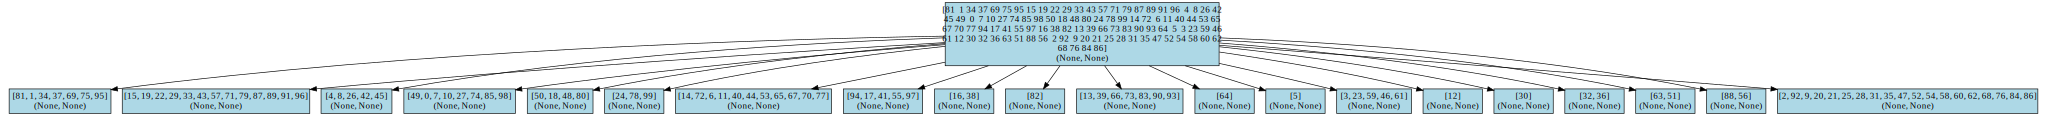

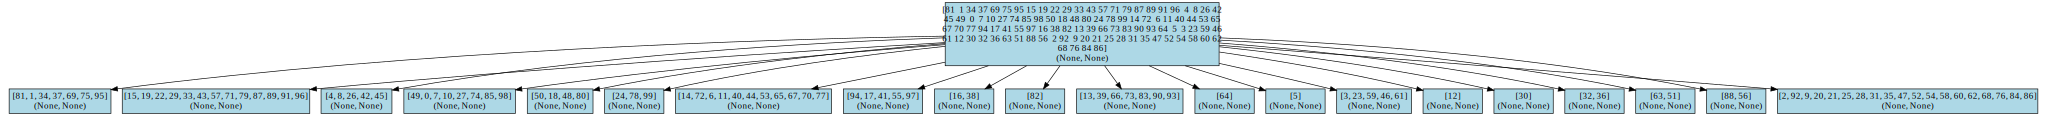

In [3]:
dyadic_sklearn.plot_tree_graphviz()

In [4]:
# Prune nodes with fewer than 50 points
min_points = 10
print(f"\nPruning nodes with fewer than {min_points} points...")
dyadic_sklearn.prune_tree_min_point(min_points)

print("\nAfter pruning:")
print(f"Tree height: {dyadic_sklearn.height}")
print("Tree structure:")
dyadic_sklearn.traverse()

# Get leaf nodes after pruning
leafs_after = dyadic_sklearn.get_all_leafs()
print(f"\nNumber of leaf nodes after pruning: {len(leafs_after)}")
if leafs_after:
    point_counts_after = [len(leaf.idxs) for leaf in leafs_after]
    print(f"Point counts in leaves: min={min(point_counts_after)}, max={max(point_counts_after)}, mean={np.mean(point_counts_after):.1f}")
else:
    print("No leaf nodes remaining!")


Pruning nodes with fewer than 10 points...

After pruning:
Tree height: 2
Tree structure:
- [81  1 34 37 69 75 95 15 19 22 29 33 43 57 71 79 87 89 91 96  4  8 26 42
 45 49  0  7 10 27 74 85 98 50 18 48 80 24 78 99 14 72  6 11 40 44 53 65
 67 70 77 94 17 41 55 97 16 38 82 13 39 66 73 83 90 93 64  5  3 23 59 46
 61 12 30 32 36 63 51 88 56  2 92  9 20 21 25 28 31 35 47 52 54 58 60 62
 68 76 84 86]
-- [15, 19, 22, 29, 33, 43, 57, 71, 79, 87, 89, 91, 96]
-- [14, 72, 6, 11, 40, 44, 53, 65, 67, 70, 77]
-- [2, 92, 9, 20, 21, 25, 28, 31, 35, 47, 52, 54, 58, 60, 62, 68, 76, 84, 86]

Number of leaf nodes after pruning: 3
Point counts in leaves: min=11, max=19, mean=14.3


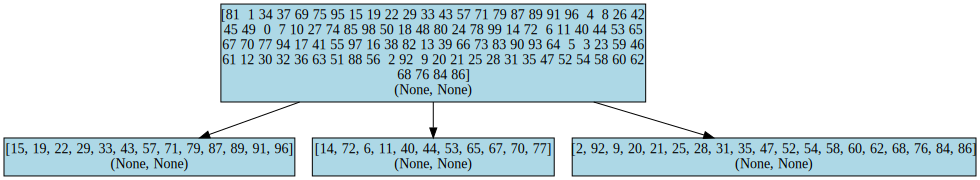

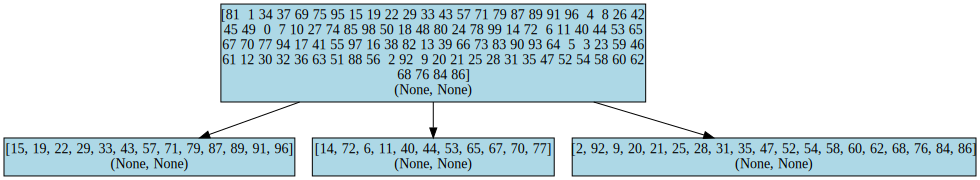

In [5]:
dyadic_sklearn.plot_tree_graphviz()

In [6]:
dyadic_sklearn.fit(X_demo)

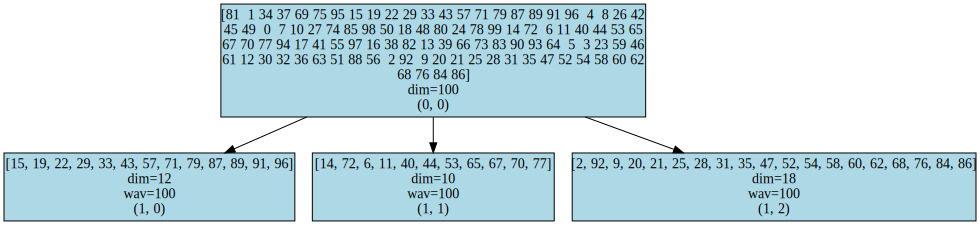

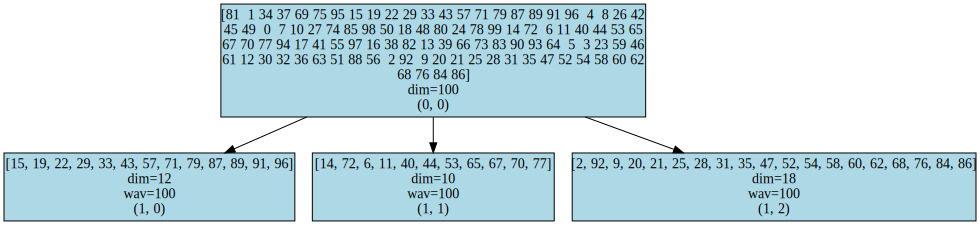

In [7]:
# plot the tree after fit basis
dyadic_sklearn.plot_tree_graphviz(show_basis_dim=True)

In [8]:
logging.getLogger().setLevel(logging.DEBUG)
feat, leafjk = dyadic_sklearn.fgwt(X_demo)

DEBUG:root:Starting forward GMRA wavelet transform for 100 data points


DEBUG:root:Found 100 leaf nodes, levels range: j=0 to j=1
DEBUG:root:Processing point 1/100, leaf at (j=0, k=0)
DEBUG:root:Processing point 1/100, leaf at (j=0, k=0)


None


ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [ ]:
feat = dyadic_sklearn.fgwt_batch(X_demo)

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 3 leaf nodes
DEBUG:root:Found 3 leaf nodes for batch processing
DEBUG:root:['(j=2, k=0)', '(j=2, k=1)', '(j=2, k=2)']
DEBUG:root:Processed leaf (j=2, k=0)
DEBUG:root:Processed node (j=1, k=0), pjx shape: (100, 13), qjx shape: (100, 13)
DEBUG:root:Processed leaf (j=2, k=1)


DEBUG:root:Processed node (j=1, k=1), pjx shape: (100, 11), qjx shape: (100, 11)
DEBUG:root:Processed leaf (j=2, k=2)
DEBUG:root:Processed node (j=1, k=2), pjx shape: (100, 18), qjx shape: (100, 18)


In [ ]:
feat.shape

(100, 382)

In [ ]:
inv, inv_each = dyadic_sklearn.igwt_batch(feat,  None, None)

DEBUG:root:Retrieving all leaf nodes from the DyadicTree
DEBUG:root:Found 3 leaf nodes
DEBUG:root:Found 3 leaf nodes for batch processing
DEBUG:root:['(j=2, k=0)', '(j=2, k=1)', '(j=2, k=2)']
DEBUG:root:Processing leaf (j=2, k=0)
DEBUG:root:Multiplying jk (j=2, k=0),                with coeff from dimension 0 to 12
DEBUG:root:Multiplying node (j=1, k=0),                    with coeff from dimension 12 to 25
DEBUG:root:Multiplying root (j=0, k=0),                with coeff from dimension 25 to 125


DEBUG:root:Processing leaf (j=2, k=1)
DEBUG:root:Multiplying jk (j=2, k=1),                with coeff from dimension 125 to 135
DEBUG:root:Multiplying node (j=1, k=1),                    with coeff from dimension 135 to 146
DEBUG:root:Multiplying root (j=0, k=0),                with coeff from dimension 146 to 246
DEBUG:root:Processing leaf (j=2, k=2)
DEBUG:root:Multiplying jk (j=2, k=2),                with coeff from dimension 246 to 264
DEBUG:root:Multiplying node (j=1, k=2),                    with coeff from dimension 264 to 282
DEBUG:root:Multiplying root (j=0, k=0),                with coeff from dimension 282 to 382


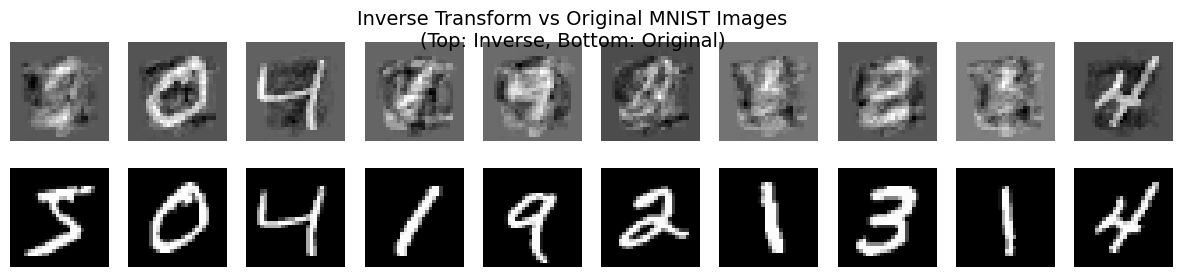

In [ ]:
# visualize inv vs X_demo
inv_images = inv_each[2].reshape(-1, 28, 28)
X_demo_images = X_demo.reshape(-1, 28, 28)

# Create subplot with 2 rows and 10 columns
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Inverse Transform vs Original MNIST Images\n(Top: Inverse, Bottom: Original)', fontsize=14)

# Plot inverse images
for i in range(10):
    axes[0, i].imshow(inv_images[i], cmap='gray')
    axes[0, i].axis('off') 

# Plot original images
for i in range(10):
    axes[1, i].imshow(X_demo_images[i], cmap='gray')
    axes[1, i].axis('off')

plt.show()


In [ ]:
dyadic_sklearn.root.is_leaf

False

In [ ]:
# gmra using fgwt and igwt

X = X_demo.copy()
dtree = DyadicTree(
    cover_tree=cover_tree_demo,
    manifold_dims=0,      # Expected intrinsic dimension
    max_dim=X.shape[-1],  # Maximum basis dimension  
    thresholds=0,       # Thresholds for basis construction
    precisions=1e-2,      # Precision parameters
    inverse=True          # Data in (n,d) format
)

DEBUG:root:Building tree at level 1, node indices: [81  1 34 37 69 75 95 15 19 22 29 33 43 57 71 79 87 89 91 96  4  8 26 42
 45 49  0  7 10 27 74 85 98 50 18 48 80 24 78 99 14 72  6 11 40 44 53 65
 67 70 77 94 17 41 55 97 16 38 82 13 39 66 73 83 90 93 64  5  3 23 59 46
 61 12 30 32 36 63 51 88 56  2 92  9 20 21 25 28 31 35 47 52 54 58 60 62
 68 76 84 86]
DEBUG:root:Updated tree height to 2
DEBUG:root:Processing internal node at level 1 with 20 children
DEBUG:root:Created child 1/20 at level 1
DEBUG:root:Building tree at level 2, node indices: [81, 1, 34, 37, 69, 75, 95]
DEBUG:root:Updated tree height to 3
DEBUG:root:Created leaf node at level 2 with indices: [81, 1, 34, 37, 69, 75, 95]
DEBUG:root:Created child 2/20 at level 1
DEBUG:root:Building tree at level 2, node indices: [15, 19, 22, 29, 33, 43, 57, 71, 79, 87, 89, 91, 96]
DEBUG:root:Created leaf node at level 2 with indices: [15, 19, 22, 29, 33, 43, 57, 71, 79, 87, 89, 91, 96]
DEBUG:root:Created child 3/20 at level 1
DEBUG:root:B

In [ ]:
dtree = dtree.fit(X)

INFO:root:Starting basis construction for DyadicTree
DEBUG:root:Computing basis for node (j=0, k=0) with 100 points, is_leaf=False


DEBUG:root:Node (j=0, k=0) basis shape: (100, 784), sigmas: 101
DEBUG:root:Processing level 1 with 20 children
DEBUG:root:Computing basis for node (j=1, k=0) with 7 points, is_leaf=False
DEBUG:root:Node (j=1, k=0) basis shape: (7, 784), sigmas: 8
DEBUG:root:Processing level 2 with 1 children
DEBUG:root:Computing basis for node (j=2, k=0) with 7 points, is_leaf=True
DEBUG:root:Node (j=2, k=0) basis shape: (6, 784), sigmas: 8
DEBUG:root:Computing basis for node (j=1, k=1) with 13 points, is_leaf=False
DEBUG:root:Node (j=1, k=1) basis shape: (13, 784), sigmas: 14
DEBUG:root:Processing level 2 with 1 children
DEBUG:root:Computing basis for node (j=2, k=1) with 13 points, is_leaf=True
DEBUG:root:Node (j=2, k=1) basis shape: (12, 784), sigmas: 14
DEBUG:root:Computing basis for node (j=1, k=2) with 5 points, is_leaf=False
DEBUG:root:Node (j=1, k=2) basis shape: (5, 784), sigmas: 6
DEBUG:root:Processing level 2 with 1 children
DEBUG:root:Computing basis for node (j=2, k=2) with 5 points, is_le

info: making wavelets


DEBUG:root:Making transform for node 20/20 at level 1
DEBUG:root:Processing wavelets for level 0 with 1 nodes
DEBUG:root:Making transform for node 1/1 at level 0


In [ ]:
z,q = dtree.fgwt(X)

DEBUG:root:Starting forward GMRA wavelet transform for 100 data points


KeyError: 0

In [ ]:
x_recon = dtree.igwt(z, q, X.shape)

NameError: name 'z' is not defined

In [ ]:
# plot x vs x_recon as mnist images

X_recon_images = x_recon.reshape(-1, 28, 28)
X_demo_images = X.reshape(-1, 28, 28)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_demo_images[i], cmap='gray')
    plt.axis('off')
    plt.subplot(2, 10, i + 11)
    plt.imshow(X_recon_images[i], cmap='gray')
    plt.axis('off')
plt.show()

NameError: name 'x_recon' is not defined

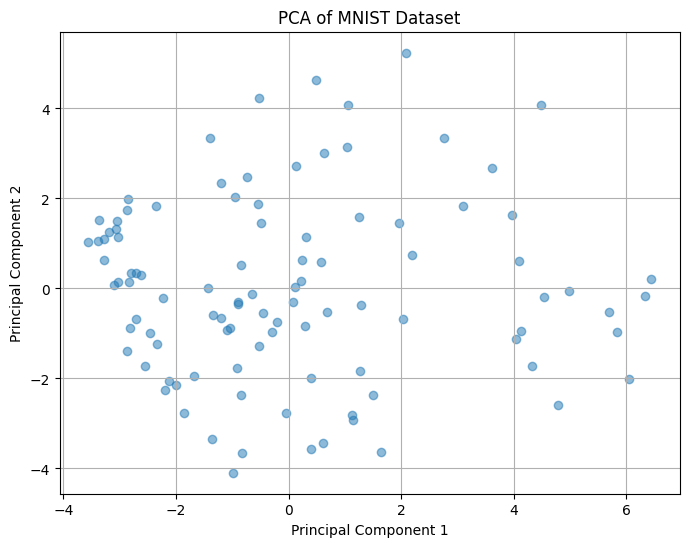

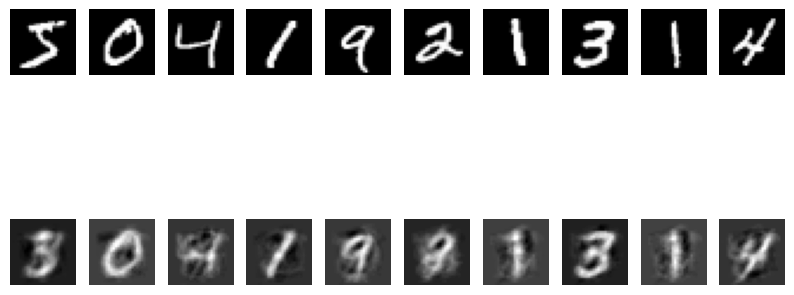

In [ ]:
# experimenttal, compute PCA for dataset and reconscutr

from sklearn.decomposition import PCA
pca = PCA(n_components=10)  # Use all components for reconstruction
X_pca = pca.fit_transform(X_demo)
# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA of MNIST Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Reconstruct using PCA
X_pca_recon = pca.inverse_transform(X_pca)
# Plot PCA reconstruction
X_pca_recon_images = X_pca_recon.reshape(-1, 28, 28)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_demo_images[i], cmap='gray')
    plt.axis('off')
    plt.subplot(2, 10, i + 11)
    plt.imshow(X_pca_recon_images[i], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# create a nxn orthogonal matrix
n = 10
Q = np.random.randn(n, n)
Q, _ = np.linalg.qr(Q)  # QR decomposition to get orthogonal matrix

In [ ]:
Q.shape

(10, 10)

In [ ]:
Qs = Q[:,:5]

In [ ]:
Qs @ Qs.T

array([[ 0.31402666, -0.01434832, -0.12409435, -0.37170645, -0.12706248,
        -0.17960651,  0.0586904 , -0.06846365, -0.06139706,  0.03658063],
       [-0.01434832,  0.31767283, -0.25883714, -0.07656368,  0.12057149,
         0.23203143, -0.15281414, -0.04229396,  0.14650246,  0.16944699],
       [-0.12409435, -0.25883714,  0.77624056, -0.00139669,  0.07355507,
        -0.12781756, -0.10978677, -0.16639817,  0.16961195, -0.03218316],
       [-0.37170645, -0.07656368, -0.00139669,  0.62144856,  0.14566579,
         0.0874613 ,  0.13145267,  0.13418062, -0.16424909,  0.00951845],
       [-0.12706248,  0.12057149,  0.07355507,  0.14566579,  0.25782674,
         0.02440369, -0.10237319, -0.11302663, -0.01840926,  0.33143801],
       [-0.17960651,  0.23203143, -0.12781756,  0.0874613 ,  0.02440369,
         0.42053855,  0.0126807 , -0.00201293,  0.34509768, -0.11725691],
       [ 0.0586904 , -0.15281414, -0.10978677,  0.13145267, -0.10237319,
         0.0126807 ,  0.85972789, -0.22474801

In [ ]:
# Method 1: Using logging levels to disable debug except for specific functions

# First, set all debug logging to WARNING (disables debug messages)
logging.getLogger().setLevel(logging.WARNING)

# Method 2: Create a custom filter to only allow debug messages from specific functions
class FunctionFilter(logging.Filter):
    def __init__(self, allowed_functions):
        super().__init__()
        self.allowed_functions = allowed_functions
    
    def filter(self, record):
        # Allow all non-debug messages
        if record.levelno > logging.DEBUG:
            return True
        
        # For debug messages, only allow if from allowed functions
        # Check if the function name is in the stack trace
        import inspect
        frame = inspect.currentframe()
        while frame:
            func_name = frame.f_code.co_name
            if func_name in self.allowed_functions:
                return True
            frame = frame.f_back
        return False

# Apply the filter to allow debug only from specific functions
debug_filter = FunctionFilter(['fgwt', 'igwt', 'fgwt_batch'])
logging.getLogger().addFilter(debug_filter)
logging.getLogger().setLevel(logging.DEBUG)

print("Debug logging is now enabled only for fgwt, igwt, and fgwt_batch functions")

In [ ]:
# Method 3: Simpler approach - Temporarily modify logging level within specific functions
# This requires modifying the source code of the functions you want to debug

# Method 4: Use a context manager to temporarily enable debug logging
import contextlib

@contextlib.contextmanager
def debug_context():
    """Context manager to temporarily enable debug logging"""
    original_level = logging.getLogger().level
    logging.getLogger().setLevel(logging.DEBUG)
    try:
        yield
    finally:
        logging.getLogger().setLevel(original_level)

# Usage example:
print("Testing selective debug logging...")

# This will NOT show debug messages
dyadic_sklearn.traverse()

# This WILL show debug messages
with debug_context():
    print("Debug messages will appear for the following operation:")
    feat, leafjk = dyadic_sklearn.fgwt(X_demo[:5])  # Only process first 5 points for demo

In [ ]:
# Method 5: Most Practical - Use string matching on debug messages
class MessageFilter(logging.Filter):
    def __init__(self, allowed_patterns):
        super().__init__()
        self.allowed_patterns = allowed_patterns
    
    def filter(self, record):
        # Allow all non-debug messages
        if record.levelno > logging.DEBUG:
            return True
        
        # For debug messages, check if message contains allowed patterns
        message = record.getMessage()
        return any(pattern in message for pattern in self.allowed_patterns)

# Remove previous filter and add new one
logging.getLogger().removeFilter(debug_filter)

# Only show debug messages containing these keywords
message_filter = MessageFilter(['fgwt', 'igwt', 'wavelet transform', 'Processing point'])
logging.getLogger().addFilter(message_filter)
logging.getLogger().setLevel(logging.DEBUG)

print("Debug logging now filtered to show only messages containing specific keywords")
print("Keywords: fgwt, igwt, wavelet transform, Processing point")

In [ ]:
# Test the updated traverse function that can return nodes
print("=== Testing the updated traverse function ===")
print()

# Create a fresh dyadic tree for testing
dyadic_test = DyadicTree(
    cover_tree=cover_tree_demo,
    manifold_dims=0,
    max_dim=X_demo.shape[-1],
    thresholds=0.0,
    precisions=1e-2,
    inverse=True
)

print("1. Traditional traverse (printing):")
dyadic_test.traverse()
print()

print("2. Get all nodes as a list:")
all_nodes = dyadic_test.get_all_nodes()
print(f"Total nodes in tree: {len(all_nodes)}")
print(f"Node indices: {[node.idxs for node in all_nodes[:5]]}...")  # Show first 5
print()

print("3. Get nodes at specific level:")
level_0_nodes = dyadic_test.get_nodes_at_level(0)
level_1_nodes = dyadic_test.get_nodes_at_level(1)
print(f"Level 0 nodes: {len(level_0_nodes)} (root)")
print(f"Level 1 nodes: {len(level_1_nodes)} (children of root)")
print()

print("4. Using traverse with return_nodes=True:")
level_1_nodes_alt = dyadic_test.traverse(only_print_level=1, return_nodes=True)
print(f"Level 1 nodes (alternative method): {len(level_1_nodes_alt)}")
print(f"Same result? {len(level_1_nodes) == len(level_1_nodes_alt)}")
print()

print("5. Verify all nodes are DyadicTreeNode instances:")
print(f"All nodes are DyadicTreeNode: {all(type(node).__name__ == 'DyadicTreeNode' for node in all_nodes)}")
print()

print("6. Tree structure verification:")
print(f"Root node: {all_nodes[0].idxs}")
print(f"Root has {len(all_nodes[0].children)} children")
print(f"Total leaf nodes: {len([node for node in all_nodes if len(node.children) == 0])}")
print(f"Total internal nodes: {len([node for node in all_nodes if len(node.children) > 0])}")